In [1]:
import os
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

#from google.colab import drive 
#drive.mount('/content/gdrive')

In [2]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [3]:
def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  img = tf.image.resize(img, (422, 512))
  img = img[tf.newaxis, :]
  return img

In [4]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

98304/83281 [===================================] - 0s 0us/step


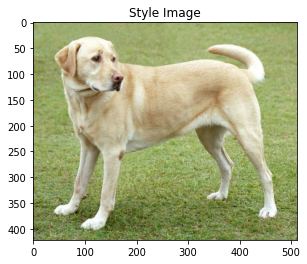

In [5]:
# Download images and choose a style image and a content image
path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 
                               'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_image = load_img(path)

plt.subplot(1, 1, 1)
imshow(style_image, 'Style Image')

In [6]:
# Creates a vgg model that returns a list of intermediate output values
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, 
                                    weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], [outputs])
  return model

In [7]:
# create the model:
style_layers = ['block5_conv1']
num_style_layers = len(style_layers)

style_extractor = vgg_layers(style_layers)
style_outputs   = style_extractor(style_image*255)
print(style_outputs[0].shape)

# Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

80150528/80134624 [==============================] - 1s 0us/step
(1, 26, 32, 512)
block5_conv1
  shape:  (1, 26, 32, 512)
  min:  0.0
  max:  3854.7976
  mean:  42.088894



In [8]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [9]:
class StyleModel(tf.keras.models.Model):
  def __init__(self, style_layers):
    super(StyleModel, self).__init__()
    self.vgg = vgg_layers(style_layers)
    self.style_layers = style_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    style_outputs = self.vgg(preprocessed_input)

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return style_dict

In [10]:
extractor = StyleModel(style_layers)
style_targets = extractor(style_image)
print(len(style_targets))

1


In [11]:
image = tf.Variable(tf.random.uniform(style_image.shape, minval=0, maxval=1))
print(image.shape)

(1, 422, 512, 3)


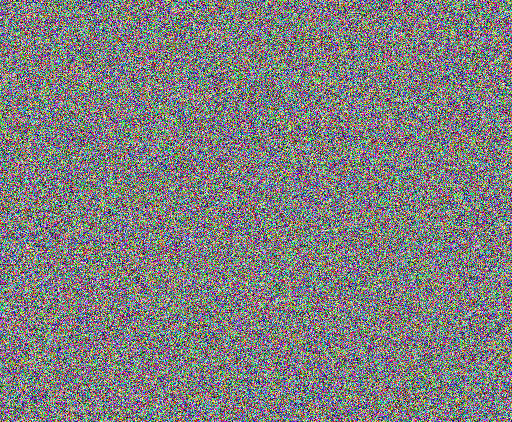

In [13]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

display.display(tensor_to_image(image))
#fname = '/content/gdrive/My Drive/data/style_transfer/OnlyStyle_v1/at_%d.png' % 0
#mpl.image.imsave(fname, image[0].numpy())

In [14]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

def style_loss(style_outputs):
    loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])    
    
    return loss

In [15]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

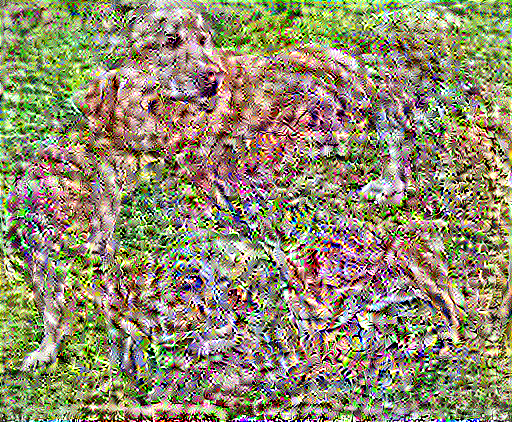

Train step: 12000
Total time: 802.5


In [ ]:
epochs = 40
steps_per_epoch = 300

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

  #fname = '/content/gdrive/My Drive/data/style_transfer/OnlyStyle_v1/at_%d.png' % (n+1)
  #mpl.image.imsave(fname, image[0].numpy())